In [40]:
# use this notebook to create some illustrative figures to show Bob
# 1/28/22 high plains chat

In [41]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up runoff rate
r = np.zeros(len(x))
r[:] = 1

# set up references to topography
Hstar = 1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.000064
atr_factor = 0.000004

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [43]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 1000000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [44]:
# EXP 1

exp_1a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

In [45]:
# run exp 1

(slope_exp_1a,
 sed_flux_exp_1a,
 e_factor_exp_1a,
 topography_exp_1a,
 bedrock_elevation_exp_1a,
 igneous_plucking_rate_exp_1a,
 sedimentary_plucking_rate_exp_1a,
 igneous_abrasion_rate_exp_1a,
 sedimentary_abrasion_rate_exp_1a,
 bedrock_erosion_rate_exp_1a,
 attrition_rate_exp_1a,
 sedimentation_rate_exp_1a,
 sediment_thickness_exp_1a,
 total_erosion_rate_exp_1a,
 cum_time_exp_1a) = two_lith_one_sed(*exp_1a)

2020204.0403882384


In [46]:
# fantastic, our system took about 2 million years to reach steady state
# now provide a tectonic "kick" to the system in the form of a tilt
upstream_tilt_factor = np.linspace(270, 1, 100)

eta_tilt_exp_1b = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1b = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1b = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1c = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1c = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1c = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1d = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1d = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1d = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1e = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1e = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1e = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1f = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1f = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1f = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1g = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1g = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1g = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1h = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1h = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1h = sediment_thickness_exp_1a.copy()

In [47]:
exp_1b = [x, dx, Hstar, H_exp_1b, etab_tilt_exp_1b, eta_tilt_exp_1b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 1]

exp_1c = [x, dx, Hstar, H_exp_1c, etab_tilt_exp_1c, eta_tilt_exp_1c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 10]

exp_1d = [x, dx, Hstar, H_exp_1d, etab_tilt_exp_1d, eta_tilt_exp_1d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 20]

exp_1e = [x, dx, Hstar, H_exp_1e, etab_tilt_exp_1e, eta_tilt_exp_1e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 50]

exp_1f = [x, dx, Hstar, H_exp_1f, etab_tilt_exp_1f, eta_tilt_exp_1f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 100]

exp_1g = [x, dx, Hstar, H_exp_1g, etab_tilt_exp_1g, eta_tilt_exp_1g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 200]

exp_1h = [x, dx, Hstar, H_exp_1h, etab_tilt_exp_1h, eta_tilt_exp_1h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 500]

In [48]:
# run the rest of exp_1

(slope_exp_1b,
 sed_flux_exp_1b,
 e_factor_exp_1b,
 topography_exp_1b,
 bedrock_elevation_exp_1b,
 igneous_plucking_rate_exp_1b,
 sedimentary_plucking_rate_exp_1b,
 igneous_abrasion_rate_exp_1b,
 sedimentary_abrasion_rate_exp_1b,
 bedrock_erosion_rate_exp_1b,
 attrition_rate_exp_1b,
 sedimentation_rate_exp_1b,
 sediment_thickness_exp_1b,
 total_erosion_rate_exp_1b,
 cum_time_exp_1b) = two_lith_one_sed(*exp_1b)

(slope_exp_1c,
 sed_flux_exp_1c,
 e_factor_exp_1c,
 topography_exp_1c,
 bedrock_elevation_exp_1c,
 igneous_plucking_rate_exp_1c,
 sedimentary_plucking_rate_exp_1c,
 igneous_abrasion_rate_exp_1c,
 sedimentary_abrasion_rate_exp_1c,
 bedrock_erosion_rate_exp_1c,
 attrition_rate_exp_1c,
 sedimentation_rate_exp_1c,
 sediment_thickness_exp_1c,
 total_erosion_rate_exp_1c,
 cum_time_exp_1c) = two_lith_one_sed(*exp_1c)

(slope_exp_1d,
 sed_flux_exp_1d,
 e_factor_exp_1d,
 topography_exp_1d,
 bedrock_elevation_exp_1d,
 igneous_plucking_rate_exp_1d,
 sedimentary_plucking_rate_exp_1d,
 igneous_abrasion_rate_exp_1d,
 sedimentary_abrasion_rate_exp_1d,
 bedrock_erosion_rate_exp_1d,
 attrition_rate_exp_1d,
 sedimentation_rate_exp_1d,
 sediment_thickness_exp_1d,
 total_erosion_rate_exp_1d,
 cum_time_exp_1d) = two_lith_one_sed(*exp_1d)

(slope_exp_1e,
 sed_flux_exp_1e,
 e_factor_exp_1e,
 topography_exp_1e,
 bedrock_elevation_exp_1e,
 igneous_plucking_rate_exp_1e,
 sedimentary_plucking_rate_exp_1e,
 igneous_abrasion_rate_exp_1e,
 sedimentary_abrasion_rate_exp_1e,
 bedrock_erosion_rate_exp_1e,
 attrition_rate_exp_1e,
 sedimentation_rate_exp_1e,
 sediment_thickness_exp_1e,
 total_erosion_rate_exp_1e,
 cum_time_exp_1e) = two_lith_one_sed(*exp_1e)

(slope_exp_1f,
 sed_flux_exp_1f,
 e_factor_exp_1f,
 topography_exp_1f,
 bedrock_elevation_exp_1f,
 igneous_plucking_rate_exp_1f,
 sedimentary_plucking_rate_exp_1f,
 igneous_abrasion_rate_exp_1f,
 sedimentary_abrasion_rate_exp_1f,
 bedrock_erosion_rate_exp_1f,
 attrition_rate_exp_1f,
 sedimentation_rate_exp_1f,
 sediment_thickness_exp_1f,
 total_erosion_rate_exp_1f,
 cum_time_exp_1f) = two_lith_one_sed(*exp_1f)

(slope_exp_1g,
 sed_flux_exp_1g,
 e_factor_exp_1g,
 topography_exp_1g,
 bedrock_elevation_exp_1g,
 igneous_plucking_rate_exp_1g,
 sedimentary_plucking_rate_exp_1g,
 igneous_abrasion_rate_exp_1g,
 sedimentary_abrasion_rate_exp_1g,
 bedrock_erosion_rate_exp_1g,
 attrition_rate_exp_1g,
 sedimentation_rate_exp_1g,
 sediment_thickness_exp_1g,
 total_erosion_rate_exp_1g,
 cum_time_exp_1g) = two_lith_one_sed(*exp_1g)

(slope_exp_1h,
 sed_flux_exp_1h,
 e_factor_exp_1h,
 topography_exp_1h,
 bedrock_elevation_exp_1h,
 igneous_plucking_rate_exp_1h,
 sedimentary_plucking_rate_exp_1h,
 igneous_abrasion_rate_exp_1h,
 sedimentary_abrasion_rate_exp_1h,
 bedrock_erosion_rate_exp_1h,
 attrition_rate_exp_1h,
 sedimentation_rate_exp_1h,
 sediment_thickness_exp_1h,
 total_erosion_rate_exp_1h,
 cum_time_exp_1h) = two_lith_one_sed(*exp_1h)

2.0202020202020203
20.202020202020204
40.40404040404041
101.01010101010102
202.02020202020205
404.0404040404041
1012.1212121211983


Text(0.5, 1.0, 'E factor')

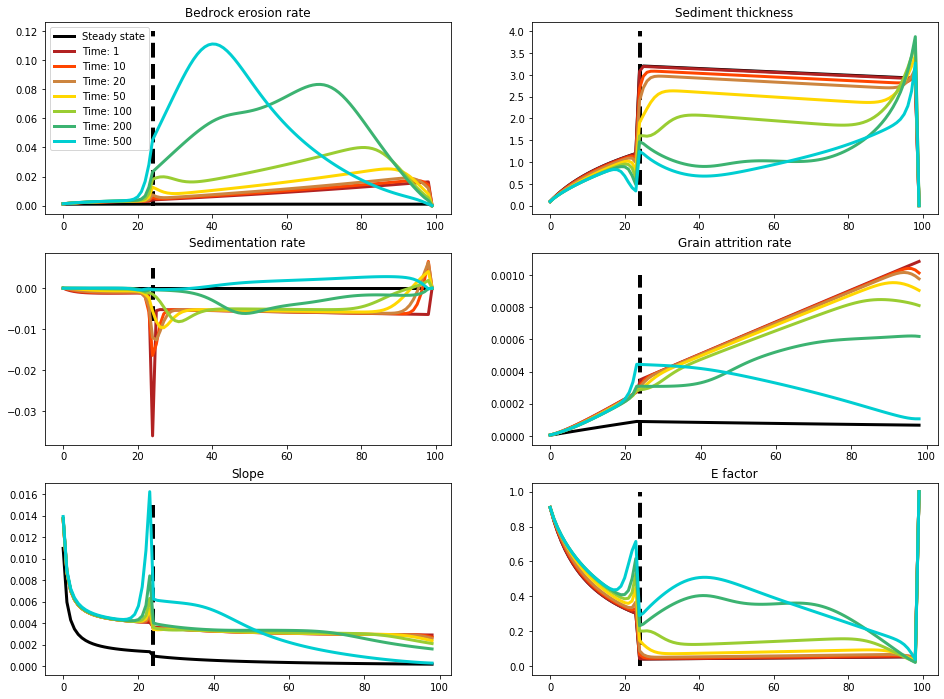

In [67]:
fig, ax = plt.subplots(3, 2, figsize = (16, 12))

ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1d, label = 'Time: 20', color = 'peru', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1e, label = 'Time: 50', color = 'gold', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1f, label = 'Time: 100', color = 'yellowgreen', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1g, label = 'Time: 200', color = 'mediumseagreen', linewidth = 3)
ax[0, 0].plot(x/1000, bedrock_erosion_rate_exp_1h, label = 'Time: 500', color = 'darkturquoise', linewidth = 3)
ax[0, 0].vlines(24, 0, 0.12, linewidth = 4, linestyle = '--')
ax[0, 0].legend(fontsize = 10)
ax[0, 0].set_title('Bedrock erosion rate', fontsize = 12)

ax[1, 0].plot(x/1000, sedimentation_rate_exp_1a, color = 'k', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1b, color = 'firebrick', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1c, color = 'orangered', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1d, color = 'peru', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1e, color = 'gold', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1f, color = 'yellowgreen', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1g, color = 'mediumseagreen', linewidth = 3)
ax[1, 0].plot(x/1000, sedimentation_rate_exp_1h, color = 'darkturquoise', linewidth = 3)
ax[1, 0].vlines(24, -0.008, 0.005, linewidth = 4, linestyle = '--')
ax[1, 0].set_title('Sedimentation rate', fontsize = 12)

ax[0, 1].plot(x/1000, sediment_thickness_exp_1a, color = 'k', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1b, color = 'firebrick', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1c, color = 'orangered', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1d, color = 'peru', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1e, color = 'gold', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1f, color = 'yellowgreen', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1g, color = 'mediumseagreen', linewidth = 3)
ax[0, 1].plot(x/1000, sediment_thickness_exp_1h, color = 'darkturquoise', linewidth = 3)
ax[0, 1].vlines(24, 0, 4, linewidth = 4, linestyle = '--')
ax[0, 1].set_title('Sediment thickness', fontsize = 12)

ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1a, color = 'k', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1b, color = 'firebrick', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1c, color = 'orangered', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1d, color = 'peru', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1e, color = 'gold', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1f, color = 'yellowgreen', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1g, color = 'mediumseagreen', linewidth = 3)
ax[1, 1].plot(x[:-1]/1000, attrition_rate_exp_1h, color = 'darkturquoise', linewidth = 3)
ax[1, 1].vlines(24, 0, 0.001, linewidth = 4, linestyle = '--')
ax[1, 1].set_title('Grain attrition rate', fontsize = 12)

ax[2, 0].plot(x[:-1]/1000, slope_exp_1a, color = 'k', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1b, color = 'firebrick', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1c, color = 'orangered', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1d, color = 'peru', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1e, color = 'gold', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1f, color = 'yellowgreen', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1g, color = 'mediumseagreen', linewidth = 3)
ax[2, 0].plot(x[:-1]/1000, slope_exp_1h, color = 'darkturquoise', linewidth = 3)
ax[2, 0].vlines(24, 0, 0.015, linewidth = 4, linestyle = '--')
ax[2, 0].set_title('Slope', fontsize = 12)

ax[2, 1].plot(x/1000, e_factor_exp_1a, color = 'k', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1b, color = 'firebrick', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1c, color = 'orangered', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1d, color = 'peru', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1e, color = 'gold', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1f, color = 'yellowgreen', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1g, color = 'mediumseagreen', linewidth = 3)
ax[2, 1].plot(x/1000, e_factor_exp_1h, color = 'darkturquoise', linewidth = 3)
ax[2, 1].vlines(24, 0, 1, linewidth = 4, linestyle = '--')
ax[2, 1].set_title('E factor', fontsize = 12)

In [68]:
# now adjust the topography and bedrock elevation back up to baselevel
diff_b = topography_exp_1b - topography_exp_1a
diff_c = topography_exp_1c - topography_exp_1a
diff_d = topography_exp_1d - topography_exp_1a
diff_e = topography_exp_1e - topography_exp_1a
diff_f = topography_exp_1f - topography_exp_1a
diff_g = topography_exp_1g - topography_exp_1a
diff_h = topography_exp_1h - topography_exp_1a

In [ ]:
fig, ax = plt.subplots